Dashboard building with temperature and abudannce of specific pollinators

import the necessary libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings

Import Data

In [4]:
df = pd.read_csv("pollinator_count_data-final.csv", sep = ',')
y = pd.read_csv("plant_on_campus_frequency.csv", sep = ',')
#getting rid of future warning signs 
warnings.filterwarnings('ignore', category = FutureWarning)

Clean up the imported data

In [5]:
#want to convert acronyms to full names 
#(hoverfly, honeybee, bumblebee, sweatbee, wasp, leafcutter, fly, beatle, butterfly)

def clean_data(df):

    #setting to print all the rows 
    pd.set_option('display.max_rows', None)

    #plants on campus data 
    df_frequency = pd.read_csv("plant_on_campus_frequency.csv",sep = ',')

    #convert european carder bee ( ECB), mason bee and carpenter bee to the leafcutter bee group (LF)
    df['pollinator'] = df['pollinator'].replace(['ECB','MB','CB'],'LB')
    #convert No information (NI) and unidentified bee (UB) to the Other pollinator group (OP)
    df['pollinator'] = df['pollinator'].replace(['NI','UB'],'OP')

    #replacing values within dataframe to favored/changed names exp. Bumble
    df['pollinator'] = df['pollinator'].replace(['BUT'],'Butterfly')
    df['pollinator'] = df['pollinator'].replace(['W'],'Wasp')
    df['pollinator'] = df['pollinator'].replace(['HF'],'Hover Fly')
    df['pollinator'] = df['pollinator'].replace(['BVO','BS','BMI','BME','BU','BI','BFL','BF','BB'],'Bumble')
    df['pollinator'] = df['pollinator'].replace(['SB'],'Sweat')
    df['pollinator'] = df['pollinator'].replace(['HB'],'Honey')
    df['pollinator'] = df['pollinator'].replace(['LB'],'Leaf Cutter')

    #using where statement to seperate OP to beetles and flies based on the insect order 

    # beetle 
    df['pollinator'] = np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'coleoptera'), 'Beetle', df['pollinator'])
    #print(df['pollinator'])

    # flies 
    df['pollinator'] =  np.where((df['pollinator'] == 'OP') & (df['insect_order'] == 'diptera'),'Fly',df['pollinator'] )
    #print(df[['pollinator','insect_order']])

    #droping all other pollinator from the data because not interested in other pollinators in data analysis
    df = df.drop(df[df['pollinator'] == 'OP'].index)
    #print(df[['pollinator','insect_order']])

    return df

In [6]:

#find the count of pollinator groups in the csv and return a percentage
pol_count = df.groupby(['pollinator'])['pollinator'].count()
print('The individual pollinator count: \n', pol_count)
print('The # of total pollinators: \n', len(df))
print('Percentage of pollinator distribution count: \n',(pol_count/len(df))*100)

The individual pollinator count: 
 pollinator
BB      13
BF       5
BFL     82
BI      32
BME     33
BMI     41
BS      12
BU       9
BUT     17
BVO    375
HB     581
HF     304
LB      20
MB       9
NI      24
OP      60
SB     267
UB       2
W       48
Name: pollinator, dtype: int64
The # of total pollinators: 
 1934
Percentage of pollinator distribution count: 
 pollinator
BB      0.672182
BF      0.258532
BFL     4.239917
BI      1.654602
BME     1.706308
BMI     2.119959
BS      0.620476
BU      0.465357
BUT     0.879007
BVO    19.389866
HB     30.041365
HF     15.718718
LB      1.034126
MB      0.465357
NI      1.240951
OP      3.102378
SB     13.805584
UB      0.103413
W       2.481903
Name: pollinator, dtype: float64


Adding in data regarding the date into seperate columns

In [8]:
def give_time(df):
    #convert the sampe_date to a datetime object
    df['sample_date'] = pd.to_datetime(df['sample_date'])
    #add a column of datetime object of month
    df['month'] = df['sample_date'].dt.month
    #add a column of datetime object of week of the year ( in terms of integer ) 
    df['Week'] = df['sample_date'].dt.week -20
    #add a column of datetime object which gives the day of the year
    df['day_of_year'] = df['sample_date'].dt.dayofweek
    
   

    #Get a column of the start of the week of all datetime objects (year, month, day )
    df['datetime_monday_week'] = df['sample_date'].dt.to_period('W').dt.start_time
    #adds a column which would shift the sample datetime object to a specific format ( month, day , and year)
    df['dates'] = df['sample_date'].dt.strftime("%b %d, %Y")
    
    return df
	


Changing the column to percentage changed columns to be graphed

In [9]:
# A function that intakes a df column and returns a list of the percent differences with the first value being 
#the baseline percentage of 100.

def turn_into_percent_difference(old_series):
    
    initial_value = old_series[0]
    #print(initial_value)
    new_list = []
    for index in old_series:
        new_list.append((index/ initial_value)*100)
    return new_list

Define a function which would give the average temperature for each week. Using a copy of the dataframe to create a column of averages, then merging that column into the original dataframe

In [10]:
def line_temp_plot(data_set):
	
	#TEST to find missing temperatures in data 
	#Result : found missing time data for C0: E and C10: A --> both have no data for count in pollinator
	#must hardcode into data as no pollinator 
	count_test = data_set.groupby(['location_number','time_code'])['location_number'].count()
	count_test = count_test.reset_index(name='counts')
	#print(count_test)

	#results 
	# week = 20 , air_temp = 15, time_code = 'E', location_number = 'CO', counts = 0
	# week = 35 , air_temp = 23, time_code = 'A', location_number = 'C10', counts = 0
	num_plot_week = data_set.groupby(['Week','air_temp','time_code','location_number'])['air_temp'].count()
	num_plot_week = num_plot_week.reset_index(name = 'counts')
	pd.set_option('display.max_rows', None)
	
	#add the two rows into the dataframe
	num_plot_week.loc[len(num_plot_week)] = [20,15,'E','C0',0]
	num_plot_week.loc[len(num_plot_week)] = [35,23,'A','C10',0]
	#print('Test Case 1:','\n',num_plot_week)

	#find the average of that specific week, then add as another column and merge that average temperatuer into the current column
	num_plot_week = num_plot_week.groupby(['Week'])['air_temp'].mean()
	num_plot_week = num_plot_week.reset_index(name = 'avg_air_temp')
	data_set = pd.merge(data_set, num_plot_week)
	
	
	return data_set

In [11]:
def average_per_week(pollinator,dates):
	#print('Test Case 1: What are the date values from the slider \n',dates[0],dates[1])

	#observation data for pollinators
	#creating a copy of the dataframe to use
	data_set = df
	data_set = clean_data(data_set)
	data_set = give_time(data_set)

	#print("Test Case :2  does give_time function work?", "\n",data_set['datetime_monday_week'])
	
	#find the total number of pollinators according to location number and time code
	#based on the pollinator request from the dropdown box
	if(pollinator == 'average'):
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
	else:
		#if the pollinator doesnt start at a specific date, sometiems it doesnt capture the entire date range 
		#new_df = pd.DataFrame({'location_number': data_set['location_number'], 'time_code': data_set['time_code']})
		#df_pivot = data_set.pivot_table(['time_code'], index='Week', columns='pollinator', aggfunc=len, fill_value=0)
		#print(df_pivot)
		#df2 = df_pivot.reset_index()
		#print(df2.columns)
		#pt_dict = pt.to_dict()
		#print(pt_dict)


		#get a dataframe which has the pollinators of the request in a df
		data_set = data_set[(data_set['pollinator'] == pollinator)]
		
		data_set['total_counts'] = data_set.groupby(['location_number','time_code'])['location_number'].transform('count')
		

		#data_set = data_set.merge(new_df, on=['location_number', 'time_code'])
		#data_set = data_set.fillna(0)


		#print(data_set.unique())

	
	
	#print("Test Case : 3  What does the dataframe look like now?", "\n",data_set)

	#creating average temerapture for all plots 
	data_set = line_temp_plot(data_set)

	#print("Test Case: 4 What does the dataframe look like now? \n", data_set)

	#getting the average pollinator mean of a specific week
	data_set['pol_mean'] = data_set.groupby(['datetime_monday_week'])['total_counts'].transform('mean')

	#print("Test Case: 5 What does the dataframe look like now? \n", data_set)

	#finding the unique average air temperature by using .last()
	data_set = data_set.groupby(['datetime_monday_week','pol_mean'])['avg_air_temp'].last()
	data_set = data_set.reset_index(name = 'avg_temp')
	
	#print("Test Case: 5 What does the dataframe look like now? \n", data_set)

	#sort the values of the column in order of date using the column datetime_monday_week
	data_set = data_set.sort_values(by = 'datetime_monday_week')

	#add another column of dates using the shift datetime since the original columns were lost during the grouby conversion
	data_set['dates'] =data_set['datetime_monday_week'].dt.strftime("%b %d")
	data_set['dates'] = data_set['dates'].astype('str')

	#print("Test Case: 6 What does the dataframe look like now? \n", data_set)

	

	#print("Test Case: 7 What does the dataframe look like now? \n", data_set)
	#print('What are the datatypes for the columns of the new df? \n',data_set.dtypes)

	#find the index of the requested date from the left slider on the implemented slider widget
	min = dates[0]
	indices_1 = data_set.index[data_set['dates'] == min].tolist()
	#print('Test Case 8: What is the index of the in value: \n',indices_1)
	
	#find the index of the requested date from the right slider on the implemented slider widget
	max = dates[1]
	indices_2 = data_set.index[data_set['dates'] == max].tolist()
	#print('Test Case 9: What is the index of the in value: \n',indices_2)

	
	#setting the max index--> if any value if larger than or equal to this value ( which is the entire length of the df)
	#use iloc to get the rest of the rows of that specific dataframe 
	#else, use iloc which the starting range of the index value from the min date to the index value of the max date +1 
	max_index = len(data_set) +1
	#print(max_index,int(indices_2[0]))
	if (int(indices_2[0]) == max_index):
		data_set = data_set.iloc[int(indices_1[0]):]
		data_set = data_set.reset_index(drop = True)
		
	else:
		data_set = data_set.iloc[int(indices_1[0]):(int(indices_2[0])+1)]
		data_set = data_set.reset_index(drop = True)

	#print("Test Case: 10 What does the dataframe look like now? \n", data_set)
	#adding the column abundance_percentage (percentage differences in a pollinator for a given week)
	data_set['Abundance_percentage'] = turn_into_percent_difference(data_set['pol_mean'])
	#adding the column temp percentage (percentage difference in the data for a given week)
	data_set['Temp_percentage'] = turn_into_percent_difference(data_set['avg_temp'])

	#print("Test Case: 11 What does the dataframe look like now? \n", data_set)
	
	#plotting the graph
	#adding two lines on a graph from two different columns, however can use the same y axis because they use the same values ( percentage difference)
	fig, ax = plt.subplots()
	ax.plot(data_set['dates'], data_set['Abundance_percentage'], linewidth=3, color='#63B7B7')
	ax.plot(data_set['dates'], data_set['Temp_percentage'], linewidth=3, color='#FF6961')
	#rotates the xticks by 60 degrees 
	plt.xticks(rotation = 60, horizontalalignment='right')
	#add a legend 
	ax.legend(['Visitations', 'Temperature'])
	ax.set_ylabel('Percent Difference (%)')
	ax.set_xlabel('Week')
	ax.set_title('Percent Difference of Average Visition Number and \n Temperature For Each Week .',
             fontname = 'Georgia', 
             fontsize= 16, 
             pad=30)
	#adding grid to the graph
	ax.grid()

	plt.show()

	

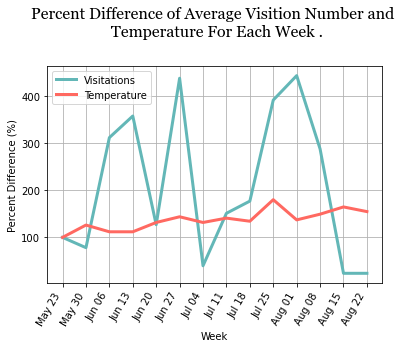

In [12]:
#print(df)
average_per_week('Bumble',['May 23','Aug 22'])

Starting the building of a dashboard
import the necessary libraries

In [13]:
import ipywidgets as widgets



Create the dashboard data filter parameters

In [14]:
#using ipywidgets
#data_set, request
#starting off with a new dataframe copy
df = clean_data(df)
df = give_time(df)

#adding datetime information
df = df.sort_values(by = 'datetime_monday_week')
df['dates'] =df['datetime_monday_week'].dt.strftime("%b %d")

#creating a list of dates to be used in the slider widget
#adding widget for sliding weeks to get specific range of month
months = df['dates'].unique()
#print('Test Case 1: What is the list content? \n',months)

#creating a list of specific pollinators to be used in the dropdown widget 
requests = df['pollinator'].unique()
requests = np.append('average',requests)
#print('Test Case 2: What is the list content? \n',requests)

#dropdown creation using requests list and giving a description name
dd1 = widgets.Dropdown(options = requests,description = 'type of pollinator')

#adding sliding tool
#create slider for the list months, and how large the index ( slider values) should be
slider = widgets.SelectionRangeSlider(
    options = months,
    index =(0, len(months)-1),
    description = 'weeks',
    disabled = False
)

#adding the two created widgets into an HBox
ui = widgets.HBox([dd1,slider])

#calling the function we want to use to create the interactive graph
out = widgets.interactive_output(average_per_week, {'pollinator': dd1,'dates' :slider})

#displaying and calling the graph
display(ui, out)




Output()